# Calcul de la variable d'intêret : Indicateur synthétique de la production 

( relatif à la partie ***3.2 - La variable d'intérêt : la production hospitalière (output)*** du rapport) 

In [23]:
# Importation des packages 
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
# Bases :
path_ID = r'C:\Users\louis\OneDrive\Documents\ENSAE\2A\Stat_app\SAE_2019\Bases_statistiques\Bases_CSV\ID_2019r.csv'
ID=pd.read_csv(path_ID ,sep=';', encoding='latin-1')
path_activ2019 =r'C:\Users\louis\OneDrive\Documents\ENSAE\2A\Stat_app\activ2019_ensae.csv'
activ2019=pd.read_csv(path_activ2019 ,sep=';')
path_ghs_priv= r'C:\Users\louis\OneDrive\Documents\ENSAE\2A\Stat_app\GHS\ghs_pri.csv'
ghs_priv=pd.read_csv(path_ghs_priv ,sep=';', encoding='latin-1')
path_ghs_pub= r'C:\Users\louis\OneDrive\Documents\ENSAE\2A\Stat_app\GHS\ghs_pub.csv'
ghs_pub=pd.read_csv(path_ghs_pub,sep=';', encoding='latin-1')
path_MCO=r'C:\Users\louis\OneDrive\Documents\ENSAE\2A\Stat_app\SAE_2019\Bases_statistiques\Bases_CSV\MCO_2019r.csv'
MCO=pd.read_csv(path_MCO ,sep=';', encoding='latin-1')

## Premières analyses de la base activ2019

In [25]:
activ2019

,finess,ghm2,_freq
0,010006526,90Z00Z,223
1,010007300,02C05J,813
2,010007300,02C08J,87
3,010007300,06K02Z,169
4,010007300,06K04J,663
...,...,...,...
153637,980500003,28Z15Z,698
153638,980500003,28Z17Z,552
153639,980500763,28Z04Z,8024
153640,980500763,90Z00Z,1085


Le code ghm "90Z00Z" représente les “Erreurs et autres séjours inclassables”, on ne prendra pas en compte ces ghm pour cette étude. Nous supprimons ces lignes de notre Dataframe. 

In [26]:
Index_90Z00Z= activ2019[ activ2019['ghm2'] == '90Z00Z' ].index
activ2019.drop(Index_90Z00Z , inplace=True)

De la même façon, le code ghm '90Z020' est lui aussi un code d'erreur. On supprime. 

In [27]:
Index_90Z02Z= activ2019[ activ2019['ghm2'] == '90Z02Z' ].index
activ2019.drop(Index_90Z02Z , inplace=True)

In [28]:
activ2019

,finess,ghm2,_freq
1,010007300,02C05J,813
2,010007300,02C08J,87
3,010007300,06K02Z,169
4,010007300,06K04J,663
5,010007300,06K05J,63
...,...,...,...
153635,980500003,28Z07Z,1453
153636,980500003,28Z14Z,427
153637,980500003,28Z15Z,698
153638,980500003,28Z17Z,552


On supprime également les codes qui touchent à la dialyse, puisque, les dialyses sont généralement faite en HAD, ce qui n'est pas la cible de notre étude, les inclure risque de complexifiéé l'analyse.

In [29]:
# liste des valeurs à exclure pour la dialyse : 
dialyse = ['28Z04Z', '28Z01Z', '28Z02Z', '28Z03Z', '90Z00Z', '28Z14Z','28Z17Z', '28Z16Z']

In [30]:
activ2019.loc[activ2019['ghm2'].isin(dialyse)]

,finess,ghm2,_freq
105,010008407,28Z14Z,72
106,010008407,28Z17Z,25
449,010780054,28Z04Z,11074
451,010780054,28Z14Z,1339
452,010780054,28Z17Z,1104
...,...,...,...
153437,970500005,28Z04Z,309
153439,970500005,28Z17Z,47
153636,980500003,28Z14Z,427
153638,980500003,28Z17Z,552


In [31]:
Index_dialyse = activ2019.loc[activ2019['ghm2'].isin(dialyse)].index

In [32]:
activ2019.drop(Index_dialyse , inplace=True)

In [33]:
activ2019['finess'].nunique()

1240

In [34]:
activ2019

,finess,ghm2,_freq
1,010007300,02C05J,813
2,010007300,02C08J,87
3,010007300,06K02Z,169
4,010007300,06K04J,663
5,010007300,06K05J,63
...,...,...,...
153632,980500003,23K02Z,67
153633,980500003,23M20T,133
153634,980500003,23M20Z,77
153635,980500003,28Z07Z,1453


La base activ2019 est dotée de 150 000 lignes mais ne représente que 1 240 établissements de santé. En effet, un établissement de santé est représenté par un ou plusieurs ghm. 

In [35]:
activ2019.groupby(by=['finess']).size().describe()

count    1240.000000
mean      121.587097
std       175.006396
min         1.000000
25%        15.000000
50%        67.000000
75%       159.000000
max      1912.000000
dtype: float64

In [36]:
activ2019.groupby(by=['finess']).size()[activ2019.groupby(by=['finess']).size()==1]

finess
030002158    1
070005558    1
070007927    1
070780366    1
080010267    1
            ..
910500040    1
920008539    1
970111662    1
970111688    1
970405411    1
Length: 88, dtype: int64

In [37]:
activ2019.groupby(by=['finess']).size()[activ2019.groupby(by=['finess']).size()==1920]

Series([], dtype: int64)

Certains établissements sont donc très diversifiés et d'autres très spécialisés. 

On souhaite fusionner activ2019 avec ID (pour les colonnes fi et stjr). Cela nous permettra d'obtenir le statut juridique regroupé de chaque établissement.

In [38]:
activ_fi_stjr= pd.merge(activ2019,ID[["fi",'stjr']],left_on="finess", right_on='fi',how='inner')
activ_fi_stjr

,finess,ghm2,_freq,fi,stjr
0,010007300,02C05J,813,010007300,2
1,010007300,02C08J,87,010007300,2
2,010007300,06K02Z,169,010007300,2
3,010007300,06K04J,663,010007300,2
4,010007300,06K05J,63,010007300,2
...,...,...,...,...,...
55934,970466751,02C09J,344,970466751,2
55935,970466751,02C11J,230,970466751,2
55936,970466751,03K02J,29,970466751,2
55937,970466751,09C03J,89,970466751,2


Cette fusion nous renvoit un Dataframe comprenant 56 913 lignes. Nous avons donc perdu 95 830 lignes suite à cette fusion. En effet, certains établissements de la base activ2019 sont représentés dans la base ID de la SAE par le  numéro finess de l'entité juridique(fi_ej) et non par le finess (fi). 
Chaque établissement de santé est représenté par un numéro finess unique. Cependant plusieurs établissements peuvent être rattachés à une même entité juridique. De ce fait, les numéros fi_ej de la base ID ne sont pas uniques :

In [39]:
print("fi_ej : ",ID["fi_ej"].size,'\n',"fi_ej uniques :",ID["fi_ej"].nunique())

fi_ej :  4018 
 fi_ej uniques : 2231


Vérifions qu'il n'est pas possible d'avoir plusieurs statuts juridiques pour la même entité : 

In [40]:
for i in ID['fi_ej'].unique() : 
    if len(ID['stjr'][ID['fi_ej'] == i]) > 1:
        if int(len(ID['stjr'][ID['fi_ej'] == i])) != int((ID['stjr'][ID['fi_ej'] == i].sum())/(ID['stjr'][ID['fi_ej'] == i].min())) : 
            print("Il peut y avoir différents statuts juridiques par entité")

In [41]:
# On retire les lignes identiques en vue de la fusion 
df = pd.DataFrame({"fi_ej": ID['fi_ej'], 'stjr':ID['stjr'] })
df.drop_duplicates(keep = 'first', inplace=True)

Nous pouvons maintenant fusionner activ2019 en fonction du numéro finess des entités juridiques. 

In [42]:
activ_fiej_stjr=pd.merge(activ2019, df , left_on = ['finess'], right_on = ['fi_ej'],how='inner')
activ_fiej_stjr

,finess,ghm2,_freq,fi_ej,stjr
0,010007987,20Z041,244,010007987,1
1,010007987,20Z042,81,010007987,1
2,010007987,23K02Z,42,010007987,1
3,010007987,23Z02Z,164,010007987,1
4,010008407,01C15J,198,010008407,1
...,...,...,...,...,...
94681,980500003,23K02Z,67,980500003,1
94682,980500003,23M20T,133,980500003,1
94683,980500003,23M20Z,77,980500003,1
94684,980500003,28Z07Z,1453,980500003,1


In [43]:
activ_stjr = pd.concat([activ_fiej_stjr, activ_fi_stjr] )
activ_stjr

,finess,ghm2,_freq,fi_ej,stjr,fi
0,010007987,20Z041,244,010007987,1,NaN
1,010007987,20Z042,81,010007987,1,NaN
2,010007987,23K02Z,42,010007987,1,NaN
3,010007987,23Z02Z,164,010007987,1,NaN
4,010008407,01C15J,198,010008407,1,NaN
...,...,...,...,...,...,...
55934,970466751,02C09J,344,NaN,2,970466751
55935,970466751,02C11J,230,NaN,2,970466751
55936,970466751,03K02J,29,NaN,2,970466751
55937,970466751,09C03J,89,NaN,2,970466751


In [44]:
activ2019['finess'].nunique()

1240

Au total, en combinant activ_fiej_stjr et activ_fi_stjr nous avons 152590  lignes. Il nous manque encore 153 lignes par rapport à la base initiale. Identifions ces éléments :

In [45]:
l=[]
for i in (activ2019['finess'].unique()):
    if activ_fiej_stjr['finess'].str.contains(i).nunique()==1 :
        l.append(i)
m=[]
for i in l :
    if activ_fi_stjr['finess'].str.contains(i).nunique()==1:
        m.append(i)
        print(i)

200200145
560002511
680021680
690781836
780150058
920008539
970500005


Ces 153 lignes correspondent à 9 établissements sanitaires. Ces établissements, n'étant pas représentés dans la SAE, seront omis de cette étude. 

(1 : Public, 2 : Privé lucratif, 3 : Privé non lucratif)

In [46]:
activ_stjr.head()

,finess,ghm2,_freq,fi_ej,stjr,fi
0,010007987,20Z041,244,010007987,1,NaN
1,010007987,20Z042,81,010007987,1,NaN
2,010007987,23K02Z,42,010007987,1,NaN
3,010007987,23Z02Z,164,010007987,1,NaN
4,010008407,01C15J,198,010008407,1,NaN


In [47]:
public = activ_stjr [(activ_stjr.stjr == 1)|(activ_stjr.stjr == 3)]
public

,finess,ghm2,_freq,fi_ej,stjr,fi
0,010007987,20Z041,244,010007987,1,NaN
1,010007987,20Z042,81,010007987,1,NaN
2,010007987,23K02Z,42,010007987,1,NaN
3,010007987,23Z02Z,164,010007987,1,NaN
4,010008407,01C15J,198,010008407,1,NaN
...,...,...,...,...,...,...
54793,950630012,17M052,31,NaN,3,950630012
54794,950630012,17M061,22,NaN,3,950630012
54795,950630012,17M062,21,NaN,3,950630012
55280,970111662,28Z07Z,4355,NaN,3,970111662


In [48]:
activ_public=pd.merge(public, ghs_pub[['GHM-NRO', 'GHS-LIB','GHS-PRI']] , left_on = ['ghm2'], right_on = ['GHM-NRO'],how='inner')
activ_public

,finess,ghm2,_freq,fi_ej,stjr,fi,GHM-NRO,GHS-LIB,GHS-PRI
0,010007987,20Z041,244,010007987,1,NaN,20Z041,"Ethylisme avec dépendance, niveau 1","2351,81"
1,010007987,20Z041,244,010007987,1,NaN,20Z041,"Ethylisme avec dépendance, niveau 1","4558,72"
2,010008407,20Z041,21,010008407,1,NaN,20Z041,"Ethylisme avec dépendance, niveau 1","2351,81"
3,010008407,20Z041,21,010008407,1,NaN,20Z041,"Ethylisme avec dépendance, niveau 1","4558,72"
4,010780054,20Z041,83,010780054,1,NaN,20Z041,"Ethylisme avec dépendance, niveau 1","2351,81"
...,...,...,...,...,...,...,...,...,...
111650,970408589,18M104,20,970408589,1,NaN,18M104,"Maladies infectieuses sévères, niveau 4","8366,47"
111651,380012658,08C57J,34,NaN,3,380012658,08C57J,Libérations articulaires du membre inférieur à...,"2187,98"
111652,920000684,05C092,22,NaN,3,920000684,05C092,"Autres interventions cardiothoraciques, âge in...","12113,04"
111653,920000684,23C023,21,NaN,3,920000684,23C023,Interventions chirurgicales avec autres motifs...,"9230,73"


In [49]:
113265 -109888 

3377

Cette base ne correspond pas à la base "public" initiale : il y a 3377 lignes supplémentaires. Généralement, à une GHM correspondant un seul GHS. Cependant, certains GHM peuvent être facturés par plusieurs GHS. Les écarts de valorisation des GHM peuvent être très significatifs. C'est pourquoi nous devrons traiter ces doublons. 

## Premières analyse de la base ghs_pub

In [50]:
ghs_pub

,GHS-NRO,CMD-COD,DCS-MCO,GHM-NRO,GHS-LIB,SEU-BAS,SEU-HAU,GHS-PRI,EXB-FORFAIT,EXB-JOURNALIER,EXH-PRI,DATE-EFFET
0,22,1,C,01C031,"Craniotomies pour traumatisme, âge supérieur à...",0,11,"3451,36",0,0,"102,08",01/03/2019
1,23,1,C,01C032,"Craniotomies pour traumatisme, âge supérieur à...",0,19,"6128,34",0,0,"84,35",01/03/2019
2,24,1,C,01C033,"Craniotomies pour traumatisme, âge supérieur à...",0,64,"11058,44",0,0,"65,45",01/03/2019
3,25,1,C,01C034,"Craniotomies pour traumatisme, âge supérieur à...",12,124,"14985,71",0,"374,03","277,61",01/03/2019
4,26,1,C,01C041,"Craniotomies en dehors de tout traumatisme, âg...",0,12,"5407,74",0,0,"125,19",01/03/2019
...,...,...,...,...,...,...,...,...,...,...,...,...
2666,9629,28,M,28Z21Z,Préparations à une irradiation externe avec do...,0,0,"426,06",0,0,0,01/03/2019
2667,9630,28,M,28Z22Z,Autres préparations à une irradiation externe,0,0,"340,53",0,0,0,01/03/2019
2668,9631,28,M,28Z23Z,Techniques complexes d'irradiation externe ave...,0,0,"166,69",0,0,0,01/03/2019
2669,9632,28,M,28Z24Z,Techniques complexes d'irradiation externe san...,0,0,"132,01",0,0,0,01/03/2019


In [51]:
# Convertion du prix des ghs en float et non en string
ghs_pub['GHS-PRI'] = [x.replace(",", ".") for x in ghs_pub['GHS-PRI']]
ghs_pub['GHS-PRI']=ghs_pub['GHS-PRI'].astype(float)

In [52]:
print( 'GHS :', ghs_pub['GHS-NRO'].nunique(), '\n', 'GHM :', ghs_pub['GHM-NRO'].nunique())

GHS : 2671 
 GHM : 2574


Certains GHS représentent plus d'un GHM. 

In [53]:
ghs_pub.describe()

,GHS-NRO,CMD-COD,SEU-BAS,SEU-HAU,GHS-PRI,EXB-FORFAIT
count,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.0
mean,3434.652565,9.501685,1.057656,18.247098,5823.722025,0.0
std,2425.612728,6.480849,3.407368,24.685641,6927.777837,0.0
min,22.000000,1.000000,0.000000,0.000000,81.850000,0.0
25%,1486.500000,5.000000,0.000000,0.000000,1749.015000,0.0
50%,2966.000000,8.000000,0.000000,10.000000,3884.610000,0.0
75%,4982.500000,13.000000,0.000000,25.000000,7246.360000,0.0
max,9633.000000,28.000000,35.000000,214.000000,83488.250000,0.0


In [54]:
ghs_pub[ghs_pub['GHS-PRI']== 81.85]

,GHS-NRO,CMD-COD,DCS-MCO,GHM-NRO,GHS-LIB,SEU-BAS,SEU-HAU,GHS-PRI,EXB-FORFAIT,EXB-JOURNALIER,EXH-PRI,DATE-EFFET
2670,9633,28,M,28Z25Z,"Autres techniques d'irradiation externe, en sé...",0,0,81.85,0,0,0,01/03/2019


In [55]:
ghs_pub[ghs_pub['GHS-PRI']== 83488.25]

,GHS-NRO,CMD-COD,DCS-MCO,GHM-NRO,GHS-LIB,SEU-BAS,SEU-HAU,GHS-PRI,EXB-FORFAIT,EXB-JOURNALIER,EXH-PRI,DATE-EFFET
2540,7860,22,C,22Z024,"Brûlures étendues, niveau 4",28,171,83488.25,0,"1081,33","1057,3",01/03/2019


## Premières analyse de la base ghs_priv

In [56]:
# Convertion du prix des ghs en float et non en string
ghs_priv['GHS-PRI'] = [x.replace(",", ".") for x in ghs_priv['GHS-PRI']]
ghs_priv['GHS-PRI']=ghs_priv['GHS-PRI'].astype(float)

In [57]:
ghs_priv

,GHS-NRO,CMD-COD,DCS-MCO,GHM-NRO,GHS-LIB,SEU-BAS,SEU-HAU,GHS-PRI,EXB-FORFAIT,EXB-JOURNALIER,EXH-PRI,DATE-EFFET
0,22,1,C,01C031,"Craniotomies pour traumatisme, âge supérieur à...",0,0,1587.53,0,0,0,01/03/2019
1,23,1,C,01C032,"Craniotomies pour traumatisme, âge supérieur à...",0,24,3022.40,0,0,"238,36",01/03/2019
2,24,1,C,01C033,"Craniotomies pour traumatisme, âge supérieur à...",0,0,7491.33,0,0,0,01/03/2019
3,25,1,C,01C034,"Craniotomies pour traumatisme, âge supérieur à...",0,0,10769.62,0,0,0,01/03/2019
4,26,1,C,01C041,"Craniotomies en dehors de tout traumatisme, âg...",0,13,2554.05,0,0,"83,34",01/03/2019
...,...,...,...,...,...,...,...,...,...,...,...,...
2607,9613,28,M,28Z14Z,"Transfusions, en séances",0,0,596.26,0,0,0,01/03/2019
2608,9614,28,M,28Z15Z,"Oxygénothérapie hyperbare, en séances",0,0,73.94,0,0,0,01/03/2019
2609,9615,28,M,28Z16Z,"Aphérèses sanguines, en séances",0,0,640.83,0,0,0,01/03/2019
2610,9616,28,M,28Z17Z,"Chimiothérapie pour affection non tumorale, en...",0,0,195.49,0,0,0,01/03/2019


In [58]:
print( 'GHS :', ghs_priv['GHS-NRO'].nunique(), '\n', 'GHM :', ghs_priv['GHM-NRO'].nunique())

GHS : 2612 
 GHM : 2530


In [59]:
ghs_priv['GHS-PRI']

0        1587.53
1        3022.40
2        7491.33
3       10769.62
4        2554.05
          ...   
2607      596.26
2608       73.94
2609      640.83
2610      195.49
2611      357.32
Name: GHS-PRI, Length: 2612, dtype: float64

In [60]:
ghs_priv.describe()

,GHS-NRO,CMD-COD,SEU-BAS,SEU-HAU,GHS-PRI,EXB-FORFAIT
count,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000,2612.0
mean,3309.426493,9.113323,0.460567,9.885911,2721.786313,0.0
std,2301.247342,6.000206,1.919177,15.979017,3008.573388,0.0
min,22.000000,1.000000,0.000000,0.000000,73.940000,0.0
25%,1470.500000,5.000000,0.000000,0.000000,819.262500,0.0
50%,2936.500000,8.000000,0.000000,0.000000,1912.110000,0.0
75%,4936.250000,13.000000,0.000000,15.000000,3399.305000,0.0
max,9617.000000,28.000000,18.000000,110.000000,23879.730000,0.0


In [61]:
ghs_priv[ghs_priv['GHS-PRI']== 73.94]

,GHS-NRO,CMD-COD,DCS-MCO,GHM-NRO,GHS-LIB,SEU-BAS,SEU-HAU,GHS-PRI,EXB-FORFAIT,EXB-JOURNALIER,EXH-PRI,DATE-EFFET
2608,9614,28,M,28Z15Z,"Oxygénothérapie hyperbare, en séances",0,0,73.94,0,0,0,01/03/2019


In [62]:
ghs_priv[ghs_priv['GHS-PRI']== 23879.730]

,GHS-NRO,CMD-COD,DCS-MCO,GHM-NRO,GHS-LIB,SEU-BAS,SEU-HAU,GHS-PRI,EXB-FORFAIT,EXB-JOURNALIER,EXH-PRI,DATE-EFFET
2584,8704,25,C,25C024,"Interventions pour maladie due au VIH, niveau 4",0,0,23879.73,0,0,0,01/03/2019


## Premières analyses ghs_pub VS ghs_priv 

In [63]:
pb= pd.DataFrame({'GHM-NRO':ghs_pub['GHM-NRO'], 'tarif_public':ghs_pub['GHS-PRI'] })
pb.drop_duplicates(subset ='GHM-NRO', keep = 'first', inplace=True)
pv= pd.DataFrame({'GHM-NRO':ghs_priv['GHM-NRO'], 'tarif_prive':ghs_priv['GHS-PRI'] })
pv.drop_duplicates(subset ='GHM-NRO', keep = 'first', inplace=True)
pb_vs_pv = pd.merge(pb,pv,how='inner')

In [64]:
pb_vs_pv['diff_tarif_pub_priv'] =  pb_vs_pv['tarif_prive'] / pb_vs_pv['tarif_public']
pb_vs_pv.describe()

,tarif_public,tarif_prive,diff_tarif_pub_priv
count,2530.000000,2530.000000,2530.000000
mean,5163.260862,2591.271715,0.512760
std,4974.110781,2803.505194,0.176752
min,257.020000,73.940000,0.067586
25%,1709.062500,803.472500,0.404581
50%,3776.260000,1861.795000,0.498225
75%,6841.560000,3263.747500,0.588664
max,44173.580000,23879.730000,1.800464


In [65]:
pb_vs_pv.sort_values('diff_tarif_pub_priv')

,GHM-NRO,tarif_public,tarif_prive,diff_tarif_pub_priv
769,05M181,4407.30,297.87,0.067586
1627,10M101,2301.86,219.04,0.095158
985,06M211,1076.41,113.59,0.105527
1629,10M103,8332.89,916.95,0.110040
1628,10M102,5530.13,620.37,0.112180
...,...,...,...,...
2497,23M16T,511.40,803.60,1.571373
2416,21M123,2538.75,4174.48,1.644305
63,01K05J,257.02,425.45,1.655319
2417,21M124,4402.54,7681.30,1.744743


## Traitement des GHM donnant lieu à plus d'un GHS 

### Pour les établissements publics 

On remarque que dans la base ghs_pub il y a au total 2671 ghs dont 2574 valeurs uniques. Il y a donc 97 ghm qui sont présents en doublons. Certains GHM sont facturés par plus de deux ghs. Voici la liste des ghm facturés par au moins deux ghs: 

In [66]:
duplic= ghs_pub[ghs_pub['GHM-NRO'].duplicated()]
duplic['GHM-NRO'].unique()

array(['01C041', '01C042', '01C043', '01C044', '01C121', '01C122',
       '01C123', '01C124', '02C091', '02C092', '02C093', '02C094',
       '02C09J', '02C021', '02C022', '02C023', '02C024', '02C02J',
       '05C061', '05C062', '05C063', '05C064', '05C021', '05C022',
       '05C023', '05C024', '05C031', '05C032', '05C033', '05C034',
       '05C081', '05C082', '05C083', '05C084', '06C19J', '06C191',
       '08C611', '08C612', '08C613', '08C614', '08C621', '08C622',
       '08C623', '08C624', '08C62J', '09C111', '09C112', '09C113',
       '09C114', '09C041', '09C042', '09C043', '09C044', '09C051',
       '09C052', '09C053', '09C054', '09C05J', '11C031', '11C032',
       '11C033', '11C034', '13C12J', '13C16J', '17K041', '19C021',
       '20Z041', '20Z042', '20Z043', '20Z044', '20Z021', '20Z022',
       '20Z023', '20Z024', '23Z02Z', '27C041', '27C042', '27C043',
       '27C044', '27C051', '27C052', '27C053', '27C054', '28Z04Z',
       '28Z11Z', '28Z18Z', '28Z19Z'], dtype=object)

In [67]:
# Création d'un dateframe avec ces valeurs uniques 
df_unique = pd.DataFrame({'GHM-NRO': duplic['GHM-NRO'].unique()})

In [68]:
# Association des ghm à toutes leurs possibilités de facturation
doublons=pd.merge(df_unique, ghs_pub[['GHM-NRO', 'GHS-LIB','GHS-PRI']] , left_on = ['GHM-NRO'], right_on = ['GHM-NRO'],how='inner')
doublons

,GHM-NRO,GHS-LIB,GHS-PRI
0,01C041,"Craniotomies en dehors de tout traumatisme, âg...",5407.74
1,01C041,"Craniotomies en dehors de tout traumatisme, âg...",11950.27
2,01C042,"Craniotomies en dehors de tout traumatisme, âg...",9017.60
3,01C042,"Craniotomies en dehors de tout traumatisme, âg...",15560.14
4,01C043,"Craniotomies en dehors de tout traumatisme, âg...",13020.04
...,...,...,...
179,28Z11Z,"Techniques spéciales d'irradiation externe, en...",761.56
180,28Z18Z,Radiothérapie conformationnelle avec modulatio...,176.53
181,28Z18Z,Radiothérapie conformationnelle avec modulatio...,373.54
182,28Z19Z,Préparations à une irradiation externe par RCM...,1068.19


In [69]:
# Liste des valeurs présentes dans le Dataframe "doublons" mais pas dans le Dataframe "public"
drop_values= []
for i in df_unique['GHM-NRO']: 
    if (i in public['ghm2'].unique()) == False : 
        drop_values.append(i)

# On retire ces valeurs que nous n'utiliserons pas pour ce projet
for i in drop_values :
    Index= doublons[doublons['GHM-NRO']==i].index
    doublons.drop(Index,inplace=True)

In [70]:
doublons

,GHM-NRO,GHS-LIB,GHS-PRI
0,01C041,"Craniotomies en dehors de tout traumatisme, âg...",5407.74
1,01C041,"Craniotomies en dehors de tout traumatisme, âg...",11950.27
2,01C042,"Craniotomies en dehors de tout traumatisme, âg...",9017.60
3,01C042,"Craniotomies en dehors de tout traumatisme, âg...",15560.14
4,01C043,"Craniotomies en dehors de tout traumatisme, âg...",13020.04
...,...,...,...
179,28Z11Z,"Techniques spéciales d'irradiation externe, en...",761.56
180,28Z18Z,Radiothérapie conformationnelle avec modulatio...,176.53
181,28Z18Z,Radiothérapie conformationnelle avec modulatio...,373.54
182,28Z19Z,Préparations à une irradiation externe par RCM...,1068.19


In [71]:
doublons['GHM-NRO'].unique()

array(['01C041', '01C042', '01C043', '01C044', '01C121', '01C122',
       '01C123', '01C124', '02C091', '02C092', '02C09J', '02C021',
       '02C022', '02C02J', '05C061', '05C062', '05C063', '05C064',
       '05C022', '05C023', '05C024', '05C031', '05C032', '05C033',
       '05C034', '05C081', '05C082', '05C083', '05C084', '06C19J',
       '06C191', '08C611', '08C612', '08C613', '08C614', '08C621',
       '08C622', '08C623', '08C624', '08C62J', '09C111', '09C112',
       '09C113', '09C041', '09C042', '09C043', '09C051', '09C052',
       '09C05J', '11C031', '11C032', '11C033', '11C034', '13C12J',
       '13C16J', '17K041', '19C021', '20Z041', '20Z042', '20Z043',
       '20Z044', '20Z021', '20Z022', '20Z023', '23Z02Z', '27C044',
       '27C053', '27C054', '28Z11Z', '28Z18Z', '28Z19Z'], dtype=object)

In [72]:
GHM_ecart_important = []
for i in doublons['GHM-NRO'].unique(): 
    if (doublons[doublons['GHM-NRO']==i]['GHS-PRI'].std()) >= 2000 : 
        GHM_ecart_important.append(i)
        print (doublons[doublons['GHM-NRO']==i])

  GHM-NRO                                            GHS-LIB   GHS-PRI
0  01C041  Craniotomies en dehors de tout traumatisme, âg...   5407.74
1  01C041  Craniotomies en dehors de tout traumatisme, âg...  11950.27
  GHM-NRO                                            GHS-LIB   GHS-PRI
2  01C042  Craniotomies en dehors de tout traumatisme, âg...   9017.60
3  01C042  Craniotomies en dehors de tout traumatisme, âg...  15560.14
  GHM-NRO                                            GHS-LIB   GHS-PRI
4  01C043  Craniotomies en dehors de tout traumatisme, âg...  13020.04
5  01C043  Craniotomies en dehors de tout traumatisme, âg...  19562.58
  GHM-NRO                                            GHS-LIB   GHS-PRI
6  01C044  Craniotomies en dehors de tout traumatisme, âg...  17050.13
7  01C044  Craniotomies en dehors de tout traumatisme, âg...  23592.66
  GHM-NRO                                            GHS-LIB   GHS-PRI
8  01C121  Craniotomies pour affections non tumorales, âg...   4810.18
9  01C

In [73]:
somme_freq=[]
for i in GHM_ecart_important:
    somme_freq.append(public[public['ghm2']==i]['_freq'].sum())

In [74]:
print("Nombre de séjours impliqués dans la problématique des doublons :",sum(somme_freq),"\n", "Nombre de séjours au total :", public['_freq'].sum(),"\n","Part en pourcentage :",sum(somme_freq)/public['_freq'].sum()*100 )

Nombre de séjours impliqués dans la problématique des doublons : 44972 
 Nombre de séjours au total : 14537639 
 Part en pourcentage : 0.3093487188669357


44 972 séjours vont être impactés par la problèmatique des doublons dans la tarification sur 17 482 445  séjours au total. Cela représente donc moins de 1% des séjours, ce qui est assez négligeable. Cependant, regardons si certains hopitaux sont largement concerné par cette problématique. 

In [75]:
public

,finess,ghm2,_freq,fi_ej,stjr,fi
0,010007987,20Z041,244,010007987,1,NaN
1,010007987,20Z042,81,010007987,1,NaN
2,010007987,23K02Z,42,010007987,1,NaN
3,010007987,23Z02Z,164,010007987,1,NaN
4,010008407,01C15J,198,010008407,1,NaN
...,...,...,...,...,...,...
54793,950630012,17M052,31,NaN,3,950630012
54794,950630012,17M061,22,NaN,3,950630012
54795,950630012,17M062,21,NaN,3,950630012
55280,970111662,28Z07Z,4355,NaN,3,970111662


In [76]:
df=pd.DataFrame({'Total_sejours':public.groupby(by=['finess'])['_freq'].sum()})
df

,Total_sejours
finess,
010007987,531
010008407,6069
010009132,41
010780054,51494
010780062,4295
...,...
970305629,3964
970403606,12962
970408589,111393


In [77]:
df2=pd.DataFrame({'GHM_ecart_important':GHM_ecart_important})
df3=pd.merge(public, df2 , left_on = ['ghm2'], right_on = ['GHM_ecart_important'],how='inner')
df4=pd.DataFrame({'Total_sejours_complexes':df3.groupby(by=['finess'])['_freq'].sum()})
df4

,Total_sejours_complexes
finess,
010007987,81
010780054,170
010780062,31
020004495,24
030780100,70
...,...
970202164,177
970211207,209
970403606,33


In [78]:
df5=pd.merge(df, df4 ,how='inner',left_on='finess',right_on='finess')
df5

,Total_sejours,Total_sejours_complexes
finess,,
010007987,531,81
010780054,51494,170
010780062,4295,31
020004495,2162,24
030780100,19426,70
...,...,...
970202164,350,177
970211207,72342,209
970403606,12962,33


Au total il y a 196 hopitaux publics ou privés à but non lucratif sont impactés par cette problématique des doublons sur 859,  soit environ 22 % des hopitaux. 

In [79]:
df5["Part_séjours_complexes (en %)"] = df5['Total_sejours_complexes']/df5['Total_sejours']*100

In [80]:
df5[df5["Part_séjours_complexes (en %)"]>10]

,Total_sejours,Total_sejours_complexes,Part_séjours_complexes (en %)
finess,,,
010007987,531,81,15.254237
210780607,424,128,30.188679
300780095,167,23,13.772455
390781193,416,110,26.442308
440028538,571,204,35.726795
440042141,297,62,20.875421
510000052,476,52,10.924370
550000095,191,24,12.565445
570000513,347,106,30.547550


14 des 196 hopitaux publics ou privés à but non lucratif ont au moins 10% de leurs séjours classés comme "séjours complexes". Deux hopitaux ont jusqu'à 100% de leurs séjours classés en "séjours complexes". 
Cette problèmatique des doublons est donc non négligeable. 

In [81]:
df5.sort_values('Part_séjours_complexes (en %)')

,Total_sejours,Total_sejours_complexes,Part_séjours_complexes (en %)
finess,,,
570005165,121388,27,0.022243
780001236,61703,21,0.034034
940110018,61073,25,0.040935
950110080,50826,22,0.043285
680020336,99013,43,0.043429
...,...,...,...
570000513,347,106,30.547550
440028538,571,204,35.726795
970202164,350,177,50.571429


In [82]:
activ2019[activ2019.finess=='590781811']

,finess,ghm2,_freq
81800,590781811,20Z022,74
81801,590781811,20Z042,32


In [83]:
df5[df5['Part_séjours_complexes (en %)']>=5].shape

(27, 3)

On retirera donc les établissements dont la part de séjours complexes est supérieure à 5%. Et on fixera tous les tarifs multiples à la moyenne de ces tarifs.  

**Résolution :**
- Fixer le prix d'un GHM correspondant à plusieurs tarifs GHS à la moyenne de ces tarifs. 
- Retirer les hopitaux où la part de séjours complexes (séjours représentés par une tarification multiple avec écart type important) représente une part importante des séjours totaux 

In [84]:
# Base correspondant aux GHM publics
ghs_pub

,GHS-NRO,CMD-COD,DCS-MCO,GHM-NRO,GHS-LIB,SEU-BAS,SEU-HAU,GHS-PRI,EXB-FORFAIT,EXB-JOURNALIER,EXH-PRI,DATE-EFFET
0,22,1,C,01C031,"Craniotomies pour traumatisme, âge supérieur à...",0,11,3451.36,0,0,"102,08",01/03/2019
1,23,1,C,01C032,"Craniotomies pour traumatisme, âge supérieur à...",0,19,6128.34,0,0,"84,35",01/03/2019
2,24,1,C,01C033,"Craniotomies pour traumatisme, âge supérieur à...",0,64,11058.44,0,0,"65,45",01/03/2019
3,25,1,C,01C034,"Craniotomies pour traumatisme, âge supérieur à...",12,124,14985.71,0,"374,03","277,61",01/03/2019
4,26,1,C,01C041,"Craniotomies en dehors de tout traumatisme, âg...",0,12,5407.74,0,0,"125,19",01/03/2019
...,...,...,...,...,...,...,...,...,...,...,...,...
2666,9629,28,M,28Z21Z,Préparations à une irradiation externe avec do...,0,0,426.06,0,0,0,01/03/2019
2667,9630,28,M,28Z22Z,Autres préparations à une irradiation externe,0,0,340.53,0,0,0,01/03/2019
2668,9631,28,M,28Z23Z,Techniques complexes d'irradiation externe ave...,0,0,166.69,0,0,0,01/03/2019
2669,9632,28,M,28Z24Z,Techniques complexes d'irradiation externe san...,0,0,132.01,0,0,0,01/03/2019


In [85]:
# Sous partie de la base activ2019 : les établissements publics ou privés à but non lucratif
public

,finess,ghm2,_freq,fi_ej,stjr,fi
0,010007987,20Z041,244,010007987,1,NaN
1,010007987,20Z042,81,010007987,1,NaN
2,010007987,23K02Z,42,010007987,1,NaN
3,010007987,23Z02Z,164,010007987,1,NaN
4,010008407,01C15J,198,010008407,1,NaN
...,...,...,...,...,...,...
54793,950630012,17M052,31,NaN,3,950630012
54794,950630012,17M061,22,NaN,3,950630012
54795,950630012,17M062,21,NaN,3,950630012
55280,970111662,28Z07Z,4355,NaN,3,970111662


On commence par retirer tous les GHM présents dans la base ghs_pub qui ne sont pas présents dans la base public. Cela limitera le temps de calcul en diminuant la taille du Datarame. On supprime donc les GHM que nous n'utiliserons pas pour l'année 2019

In [86]:
# Liste des valeurs présentes dans le Dataframe "ghs_pub" mais pas dans le Dataframe "public"
drop_values= []
for i in ghs_pub['GHM-NRO'].unique(): 
    if (i in public['ghm2'].unique()) == False : 
        drop_values.append(i)
        
# On retire ces valeurs que nous n'utiliserons pas pour ce projet
for i in drop_values :
    Index= ghs_pub[ghs_pub['GHM-NRO']==i].index
    ghs_pub.drop(Index,inplace=True)

In [87]:
# Création d'un prix unique pour chaque GHM 
for i in ghs_pub['GHM-NRO'].unique():
    moyenne = ghs_pub[ghs_pub['GHM-NRO']==i]['GHS-PRI'].mean()
    Indexs_ghs_pub = ghs_pub[ghs_pub['GHM-NRO']==i].index
    ghs_pub['GHS-PRI'][Indexs_ghs_pub] = float(moyenne)
ghs_pub

<ipython-input-87-c866dab36ea0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ghs_pub['GHS-PRI'][Indexs_ghs_pub] = float(moyenne)
C:\Users\louis\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,GHS-NRO,CMD-COD,DCS-MCO,GHM-NRO,GHS-LIB,SEU-BAS,SEU-HAU,GHS-PRI,EXB-FORFAIT,EXB-JOURNALIER,EXH-PRI,DATE-EFFET
0,22,1,C,01C031,"Craniotomies pour traumatisme, âge supérieur à...",0,11,3451.360,0,0,"102,08",01/03/2019
1,23,1,C,01C032,"Craniotomies pour traumatisme, âge supérieur à...",0,19,6128.340,0,0,"84,35",01/03/2019
2,24,1,C,01C033,"Craniotomies pour traumatisme, âge supérieur à...",0,64,11058.440,0,0,"65,45",01/03/2019
3,25,1,C,01C034,"Craniotomies pour traumatisme, âge supérieur à...",12,124,14985.710,0,"374,03","277,61",01/03/2019
4,26,1,C,01C041,"Craniotomies en dehors de tout traumatisme, âg...",0,12,8679.005,0,0,"125,19",01/03/2019
...,...,...,...,...,...,...,...,...,...,...,...,...
2666,9629,28,M,28Z21Z,Préparations à une irradiation externe avec do...,0,0,426.060,0,0,0,01/03/2019
2667,9630,28,M,28Z22Z,Autres préparations à une irradiation externe,0,0,340.530,0,0,0,01/03/2019
2668,9631,28,M,28Z23Z,Techniques complexes d'irradiation externe ave...,0,0,166.690,0,0,0,01/03/2019
2669,9632,28,M,28Z24Z,Techniques complexes d'irradiation externe san...,0,0,132.010,0,0,0,01/03/2019


In [88]:
# On retire les lignes identiques en vue de la fusion 
ghs_pub.drop_duplicates(subset ='GHM-NRO', keep = 'first', inplace=True)

In [89]:
# On fusionne public et ghs_pub 
public_ghm= pd.merge(public,ghs_pub[["GHM-NRO",'GHS-PRI']],left_on="ghm2", right_on='GHM-NRO',how='inner')
public_ghm

,finess,ghm2,_freq,fi_ej,stjr,fi,GHM-NRO,GHS-PRI
0,010007987,20Z041,244,010007987,1,NaN,20Z041,3455.265
1,010008407,20Z041,21,010008407,1,NaN,20Z041,3455.265
2,010780054,20Z041,83,010780054,1,NaN,20Z041,3455.265
3,020000022,20Z041,43,020000022,1,NaN,20Z041,3455.265
4,020000261,20Z041,96,020000261,1,NaN,20Z041,3455.265
...,...,...,...,...,...,...,...,...
107697,970408589,18M104,20,970408589,1,NaN,18M104,8366.470
107698,380012658,08C57J,34,NaN,3,380012658,08C57J,2187.980
107699,920000684,05C092,22,NaN,3,920000684,05C092,12113.040
107700,920000684,23C023,21,NaN,3,920000684,23C023,9230.730


In [90]:
public_ghm.shape[0]/ public.shape[0] *100

99.23250564334086

La base public_ghm représente 99% de la base public. Certains GHM présents dans la base initiale sont absents de la table de tarification. Identifions les : 

In [91]:
# Liste des valeurs présentes dans le Dataframe "public" mais pas dans le Dataframe "public_ghm"
Public_pasghm= []
for i in public['ghm2'].unique(): 
    if (i in ghs_pub['GHM-NRO'].unique()) == False : 
        Public_pasghm.append(i)

In [92]:
Public_pasghm

['14Z08Z',
 '11C091',
 '09C06T',
 '11C09J',
 '09Z02A',
 '15Z10E',
 '23Z03Z',
 '05K211',
 '05K212',
 '05K213',
 '11C092',
 '11C093',
 '11C094',
 '05K214']

Grace au site https://www.aideaucodage.fr/ghm-05k212 on peut identifier à quoi correspondent les codes ci-dessus. Nous les étudions un à un pour déterminer s'ils sont remplaçable ou non : 
- '14Z08Z' correspond aux IVG, dans la base ghm les IVG sont représenté par les codes "14Z04T" et "14Z04Z", nous associons donc au ghm '14Z08Z' la moyenne des deux tarifs des IVG. 
- '11C091','11C092' ,'11C093', '11C094',  '11C09J': Créations et réfections de fistules artérioveineuses pour affections de la CMD 11, niveau 1,2,3,4 : On trouve les tarifs correspondants https://www.lespmsi.com/les-ghs-multi-ghm-en-2018-dgf-et-oqn/
- '09C06T' : on trouve egalement sur https://www.lespmsi.com/les-ghs-multi-ghm-en-2018-dgf-et-oqn/
- '09Z02A' : on met la tarification du 09Z02B 
- '23Z03Z': code d'erreur: on supprime
- '05K211','05K212','05K213', '05K214': On les retrouve https://www.lespmsi.com/les-ghs-multi-ghm-en-2018-dgf-et-oqn/
- '15Z10E' : on supprime

In [93]:
# Pour le GHM 14Z08Z
prix_14Z08Z = int(ghs_pub[ghs_pub['GHM-NRO']=='14Z04T']['GHS-PRI']*(1/2)) + int((1/2)*ghs_pub[ghs_pub['GHM-NRO']=='14Z04Z']['GHS-PRI'])
ghs_pub= ghs_pub.append({'GHM-NRO':'14Z08Z','GHS-PRI':prix_14Z08Z}, ignore_index=True)

In [94]:
# Pour les GHM '11C091','11C092' ,'11C093', '11C094',  '11C09J'
ghs_pub= ghs_pub.append({'GHM-NRO':'11C091','GHS-PRI':1731.76 }, ignore_index=True)
ghs_pub= ghs_pub.append({'GHM-NRO':'11C092','GHS-PRI':5273.18 }, ignore_index=True)
ghs_pub= ghs_pub.append({'GHM-NRO':'11C093','GHS-PRI':9667.24  }, ignore_index=True)
ghs_pub= ghs_pub.append({'GHM-NRO':'11C094','GHS-PRI':13698.25 }, ignore_index=True)
ghs_pub= ghs_pub.append({'GHM-NRO':'11C09J','GHS-PRI':1731.76 }, ignore_index=True)


In [95]:
# Pour les GHM '09C06T' : 
ghs_pub= ghs_pub.append({'GHM-NRO':'09C06T','GHS-PRI':2440.05 }, ignore_index=True)

In [96]:
# Pour les GHM '09Z02A' : 
ghs_pub= ghs_pub.append({'GHM-NRO':'09Z02A','GHS-PRI':3494.55 }, ignore_index=True)

In [97]:
# Pour le GHM 23Z03Z
Index_23Z03Z= public[ public['ghm2'] == '23Z03Z' ].index
public.drop(Index_23Z03Z , inplace=True)

C:\Users\louis\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [98]:
# Pour le GHM 15Z10E
Index_15Z10E= public[ public['ghm2'] == '15Z10E' ].index
public.drop(Index_15Z10E , inplace=True)

In [99]:
# Pour les GHM  '05K211','05K212','05K213', '05K214'
ghs_pub= ghs_pub.append({'GHM-NRO':'05K211','GHS-PRI':7041.3 }, ignore_index=True)
ghs_pub= ghs_pub.append({'GHM-NRO':'05K212','GHS-PRI':7935.83}, ignore_index=True)
ghs_pub= ghs_pub.append({'GHM-NRO':'05K213','GHS-PRI':9255.16}, ignore_index=True)
ghs_pub= ghs_pub.append({'GHM-NRO':'05K214','GHS-PRI':7041.3 }, ignore_index=True)

On fusionne avec ces nouvelles modifications 

In [100]:
# On fusionne public et ghs_pub 
public_ghm= pd.merge(public,ghs_pub[["GHM-NRO",'GHS-PRI']],left_on="ghm2", right_on='GHM-NRO',how='inner')
public_ghm

,finess,ghm2,_freq,fi_ej,stjr,fi,GHM-NRO,GHS-PRI
0,010007987,20Z041,244,010007987,1,NaN,20Z041,3455.265
1,010008407,20Z041,21,010008407,1,NaN,20Z041,3455.265
2,010780054,20Z041,83,010780054,1,NaN,20Z041,3455.265
3,020000022,20Z041,43,020000022,1,NaN,20Z041,3455.265
4,020000261,20Z041,96,020000261,1,NaN,20Z041,3455.265
...,...,...,...,...,...,...,...,...
108432,970408589,18M104,20,970408589,1,NaN,18M104,8366.470
108433,380012658,08C57J,34,NaN,3,380012658,08C57J,2187.980
108434,920000684,05C092,22,NaN,3,920000684,05C092,12113.040
108435,920000684,23C023,21,NaN,3,920000684,23C023,9230.730


Rappelons que nous avons fait la moyenne des tarifs multiples même pour ceux dont l'écart type était élevé. Il faut revenir sur cette hypothèse pour ne pas biaiser notre étude. 
Nous retirons les hopitaux pour qui ces tarifs complexes vont significativement impacter leur production. 
Dans l'étude des GHM multiples effectuée plus haut (base "doublons"), nous avions établie une liste  des GHM donnant lieux à une tarification complexe (écart type suppérieur à 2 000 entre les différentes tarifications) et un Dataframe permettant d'identifier la part des séjours complexes parmi l'ensemble des séjours. Nous supprimerons de notre étude les hopitaux dont la part de séjours complexes est suppérieure à 5% des séjours totaux.  Voici la liste de ces établissements :

In [101]:
df5[df5["Part_séjours_complexes (en %)"]>5]

,Total_sejours,Total_sejours_complexes,Part_séjours_complexes (en %)
finess,,,
010007987,531,81,15.254237
110780772,534,39,7.303371
130781339,3626,207,5.708770
140000159,2312,141,6.098616
210780607,424,128,30.188679
270000110,441,26,5.895692
290000751,763,40,5.242464
300780095,167,23,13.772455
390781193,416,110,26.442308


In [102]:
len(df5[df5["Part_séjours_complexes (en %)"]>5])/public_ghm['finess'].nunique() * 100 

3.6193029490616624

Nous retirons environ 3% des établissements en raison de cette tarification complexe. 

In [103]:
finess_tarif_complexe=df5[df5["Part_séjours_complexes (en %)"]>5].index

#### Analyse des établissements publics dont la production est fortement influencée par la tarification multiple: 

In [104]:
len(finess_tarif_complexe)

27

Il y a 27 établissements dont la production est fortement influencée par la tarification multiple

In [105]:
public_ghm[public_ghm['finess']=='010007987']

,finess,ghm2,_freq,fi_ej,stjr,fi,GHM-NRO,GHS-PRI
0,010007987,20Z041,244,010007987,1,NaN,20Z041,3455.265000
241,010007987,20Z042,81,010007987,1,NaN,20Z042,4706.030000
416,010007987,23K02Z,42,010007987,1,NaN,23K02Z,502.170000
708,010007987,23Z02Z,164,010007987,1,NaN,23Z02Z,5098.133333


In [106]:
df5

,Total_sejours,Total_sejours_complexes,Part_séjours_complexes (en %)
finess,,,
010007987,531,81,15.254237
010780054,51494,170,0.330136
010780062,4295,31,0.721769
020004495,2162,24,1.110083
030780100,19426,70,0.360342
...,...,...,...
970202164,350,177,50.571429
970211207,72342,209,0.288905
970403606,12962,33,0.254590


In [107]:
df.Total_sejours.describe()

count    7.460000e+02
mean     1.948745e+04
std      5.311612e+04
min      2.000000e+01
25%      4.497500e+02
50%      5.651500e+03
75%      1.948075e+04
max      1.168097e+06
Name: Total_sejours, dtype: float64

In [108]:
df5.loc[finess_tarif_complexe].Total_sejours.describe()

count       27.000000
mean      1602.629630
std       2812.613391
min         68.000000
25%        348.500000
50%        531.000000
75%       1173.500000
max      11175.000000
Name: Total_sejours, dtype: float64

Les hopitaux fortement impactés par ces tarifs multiples sont des hopitaux dont le nombre de séjours est assez faible ( en moyenne 1628 contre 54 000 en moyenne sur l'ensemble des établissements). 

En regardant le type d'établissement pour chaque numéro finess identifié, on se rend compte que ce sont, pour la plupart, des hopitaux prenant en charge les personnes dépendantes ( handicaps, personnes agées...) ou des centres de soins de suite et de réadaptation enaddictologie.

In [109]:
MCO.FI_EJ

0       010780054
1       010780062
2       010780096
3       010780120
4       010780138
          ...    
1635    970400255
1636    970400305
1637    970400446
1638    980500003
1639    970407250
Name: FI_EJ, Length: 1640, dtype: object

In [110]:
nb_lits=[]
for i in finess_tarif_complexe : 
    nb_lits.append(MCO[MCO.FI_EJ==i]['LIT_MCO'].mean())
    

In [111]:
nb_lits

[12.0,
 37.0,
 37.0,
 63.0,
 18.0,
 34.0,
 21.0,
 21.0,
 nan,
 59.0,
 25.0,
 15.0,
 15.0,
 10.0,
 20.0,
 10.0,
 48.0,
 44.0,
 64.0,
 nan,
 6.0,
 106.0,
 18.0,
 24.0,
 25.0,
 nan,
 32.0]

In [112]:
MCO.groupby(['FI_EJ'])['LIT_MCO'].mean().mean()

118.74759657905717

In [113]:
MCO.groupby(['FI'])['LIT_MCO'].mean().mean()

136.9477966101695

Moyenne de 31 lits dans les établissements où la production est fortement influencée par les tarifs complexes, contre une moyenne de plus de 120 dans la totalité des établissements. 

In [114]:
finess_tarif_complexe

Index(['010007987', '110780772', '130781339', '140000159', '210780607',
       '270000110', '290000751', '300780095', '390781193', '440028538',
       '440042141', '510000052', '550000095', '570000513', '590780052',
       '590781811', '590782207', '610780124', '620100677', '690780150',
       '710781329', '750062036', '800000051', '800000135', '890000052',
       '920000684', '970202164'],
      dtype='object', name='finess')

In [115]:
# On retire de la base les établissements dont la production est fortement influencée par les tarifs multiples à écart type élevé
for i in finess_tarif_complexe :
    indexNames = public_ghm[public_ghm['finess']==i].index
    public_ghm.drop(indexNames,inplace=True)

In [116]:
public_ghm

,finess,ghm2,_freq,fi_ej,stjr,fi,GHM-NRO,GHS-PRI
1,010008407,20Z041,21,010008407,1,NaN,20Z041,3455.265
2,010780054,20Z041,83,010780054,1,NaN,20Z041,3455.265
3,020000022,20Z041,43,020000022,1,NaN,20Z041,3455.265
4,020000261,20Z041,96,020000261,1,NaN,20Z041,3455.265
5,020000287,20Z041,39,020000287,1,NaN,20Z041,3455.265
...,...,...,...,...,...,...,...,...
108430,970211207,08C063,27,970211207,1,NaN,08C063,12756.570
108431,970302022,21M123,22,970302022,1,NaN,21M123,2538.750
108432,970408589,18M104,20,970408589,1,NaN,18M104,8366.470
108433,380012658,08C57J,34,NaN,3,380012658,08C57J,2187.980


In [117]:
public_ghm.groupby(['finess'])['GHS-PRI'].sum()

finess
010008407    1.650548e+05
010009132    5.715170e+03
010780054    7.919023e+05
010780062    1.885581e+05
010780096    9.075654e+04
                 ...     
970305629    9.459523e+04
970403606    3.325696e+05
970408589    2.702726e+06
970421038    5.785114e+05
980500003    3.849013e+05
Name: GHS-PRI, Length: 719, dtype: float64

In [118]:
public_ghm

,finess,ghm2,_freq,fi_ej,stjr,fi,GHM-NRO,GHS-PRI
1,010008407,20Z041,21,010008407,1,NaN,20Z041,3455.265
2,010780054,20Z041,83,010780054,1,NaN,20Z041,3455.265
3,020000022,20Z041,43,020000022,1,NaN,20Z041,3455.265
4,020000261,20Z041,96,020000261,1,NaN,20Z041,3455.265
5,020000287,20Z041,39,020000287,1,NaN,20Z041,3455.265
...,...,...,...,...,...,...,...,...
108430,970211207,08C063,27,970211207,1,NaN,08C063,12756.570
108431,970302022,21M123,22,970302022,1,NaN,21M123,2538.750
108432,970408589,18M104,20,970408589,1,NaN,18M104,8366.470
108433,380012658,08C57J,34,NaN,3,380012658,08C57J,2187.980


In [119]:
public_ghm[public_ghm['finess']== '10008407']

,finess,ghm2,_freq,fi_ej,stjr,fi,GHM-NRO,GHS-PRI


In [120]:
ISA_public = pd.DataFrame({'Numero_finess': public_ghm.groupby(['finess'])['GHS-PRI'].sum().index , 'Points_ISA' : public_ghm.groupby(['finess'])['GHS-PRI'].sum(), "stjr":public_ghm.groupby(['finess'])['stjr'].min()})
ISA_public.index = range(0,ISA_public.shape[0],1)
ISA_public

,Numero_finess,Points_ISA,stjr
0,010008407,1.650548e+05,1
1,010009132,5.715170e+03,1
2,010780054,7.919023e+05,1
3,010780062,1.885581e+05,1
4,010780096,9.075654e+04,1
...,...,...,...
714,970305629,9.459523e+04,1
715,970403606,3.325696e+05,1
716,970408589,2.702726e+06,1
717,970421038,5.785114e+05,1


### Pour les établissements privés  

In [121]:
# Récupération des établissements privés de la base activ2019
prive = activ_stjr [(activ_stjr.stjr == 2)]
prive

,finess,ghm2,_freq,fi_ej,stjr,fi
0,010007300,02C05J,813,NaN,2,010007300
1,010007300,02C08J,87,NaN,2,010007300
2,010007300,06K02Z,169,NaN,2,010007300
3,010007300,06K04J,663,NaN,2,010007300
4,010007300,06K05J,63,NaN,2,010007300
...,...,...,...,...,...,...
55934,970466751,02C09J,344,NaN,2,970466751
55935,970466751,02C11J,230,NaN,2,970466751
55936,970466751,03K02J,29,NaN,2,970466751
55937,970466751,09C03J,89,NaN,2,970466751


In [122]:
print( 'Nombre total de tarification GHM :', ghs_priv.shape[0] , '\n', 'Nombre total de tarification unique : ', ghs_priv['GHM-NRO'].nunique())

Nombre total de tarification GHM : 2612 
 Nombre total de tarification unique :  2530


On remarque que dans la base ghs_pub il y a au total 2612 ghs dont 2530 valeurs uniques. On est donc là encore dans une situation où certains GHM sont facturés par plusieurs ghs. Voici la liste des ghm facturés par au moins deux ghs: 

In [123]:
duplic_priv= ghs_priv[ghs_priv['GHM-NRO'].duplicated()]
duplic_priv['GHM-NRO'].unique()

array(['01C041', '01C042', '01C043', '01C044', '01C121', '01C122',
       '01C123', '01C124', '02C091', '02C092', '02C093', '02C094',
       '02C09J', '02C021', '02C022', '02C023', '02C024', '02C02J',
       '05C061', '05C062', '05C063', '05C064', '05C021', '05C022',
       '05C023', '05C024', '05C031', '05C032', '05C033', '05C034',
       '05C081', '05C082', '05C083', '05C084', '06C19J', '06C191',
       '08C611', '08C612', '08C613', '08C614', '08C621', '08C622',
       '08C623', '08C624', '08C62J', '09C111', '09C112', '09C113',
       '09C114', '09C041', '09C042', '09C043', '09C044', '09C051',
       '09C052', '09C053', '09C054', '09C05J', '11C031', '11C032',
       '11C033', '11C034', '13C12J', '17K041', '19C021', '20Z041',
       '20Z042', '20Z043', '20Z044', '20Z021', '20Z022', '20Z023',
       '20Z024', '23Z02Z', '28Z04Z'], dtype=object)

In [124]:
# Création d'un dateframe avec ces valeurs uniques 
df_unique_priv = pd.DataFrame({'GHM-NRO': duplic_priv['GHM-NRO'].unique()})

In [125]:
# Association des ghm à toutes leurs possibilités de facturation
doublons_priv=pd.merge(df_unique_priv, ghs_priv[['GHM-NRO', 'GHS-LIB','GHS-PRI']] , left_on = ['GHM-NRO'], right_on = ['GHM-NRO'],how='inner')
doublons_priv

,GHM-NRO,GHS-LIB,GHS-PRI
0,01C041,"Craniotomies en dehors de tout traumatisme, âg...",2554.05
1,01C041,"Craniotomies en dehors de tout traumatisme, âg...",9395.14
2,01C042,"Craniotomies en dehors de tout traumatisme, âg...",4632.48
3,01C042,"Craniotomies en dehors de tout traumatisme, âg...",11473.57
4,01C043,"Craniotomies en dehors de tout traumatisme, âg...",6535.06
...,...,...,...
152,23Z02Z,"Soins Palliatifs, avec ou sans acte",3007.35
153,23Z02Z,"Soins Palliatifs, avec ou sans acte",3907.06
154,23Z02Z,"Soins Palliatifs, avec ou sans acte",4508.02
155,28Z04Z,"Hémodialyse, en séances",251.78


In [126]:
# Liste des valeurs présentes dans le Dataframe "doublons" mais pas dans le Dataframe "public"
drop_values_priv= []
for i in df_unique_priv['GHM-NRO']: 
    if (i in prive['ghm2'].unique()) == False : 
        drop_values_priv.append(i)

# On retire ces valeurs que nous n'utiliserons pas pour ce projet
for i in drop_values_priv :
    Index= doublons[doublons['GHM-NRO']==i].index
    doublons_priv.drop(Index,inplace=True)

In [127]:
GHM_ecart_important_prive = []
for i in doublons_priv['GHM-NRO'].unique(): 
    if (doublons_priv[doublons_priv['GHM-NRO']==i]['GHS-PRI'].std()) >= 2000 : 
        GHM_ecart_important_prive.append(i)
        print (doublons_priv[doublons_priv['GHM-NRO']==i])

  GHM-NRO                                            GHS-LIB  GHS-PRI
0  01C041  Craniotomies en dehors de tout traumatisme, âg...  2554.05
1  01C041  Craniotomies en dehors de tout traumatisme, âg...  9395.14
  GHM-NRO                                            GHS-LIB   GHS-PRI
2  01C042  Craniotomies en dehors de tout traumatisme, âg...   4632.48
3  01C042  Craniotomies en dehors de tout traumatisme, âg...  11473.57
  GHM-NRO                                            GHS-LIB   GHS-PRI
4  01C043  Craniotomies en dehors de tout traumatisme, âg...   6535.06
5  01C043  Craniotomies en dehors de tout traumatisme, âg...  13376.14
  GHM-NRO                                            GHS-LIB   GHS-PRI
6  01C044  Craniotomies en dehors de tout traumatisme, âg...  10638.06
7  01C044  Craniotomies en dehors de tout traumatisme, âg...  17479.14
    GHM-NRO                        GHS-LIB  GHS-PRI
130  17K041  Autres irradiations, niveau 1  1140.54
131  17K041  Autres irradiations, niveau 1  588

In [128]:
somme_freq_priv=[]
for i in GHM_ecart_important_prive:
    somme_freq_priv.append(prive[prive['ghm2']==i]['_freq'].sum())

In [129]:
print("Nombre de séjours impliqués dans la problématique des doublons :",sum(somme_freq_priv),"\n", "Nombre de séjours au total :", prive['_freq'].sum(),"\n","Part en pourcentage :",sum(somme_freq)/prive['_freq'].sum()*100 )

Nombre de séjours impliqués dans la problématique des doublons : 1840 
 Nombre de séjours au total : 6348911 
 Part en pourcentage : 0.7083419502966729


La part des séjours impactés par la tarification multiple est de moins de 1%, ce qui est assez négligeable. Regardons comment est impactée la fonction de production par hopitaux. 

In [130]:
df_priv=pd.DataFrame({'Total_sejours':prive.groupby(by=['finess'])['_freq'].sum()})
df2_priv=pd.DataFrame({'GHM_ecart_important_prive': GHM_ecart_important_prive})
df3_priv=pd.merge(prive, df2_priv , left_on = ['ghm2'], right_on = ['GHM_ecart_important_prive'],how='inner')
df4_priv=pd.DataFrame({'Total_sejours_complexes':df3_priv.groupby(by=['finess'])['_freq'].sum()})
df5_priv=pd.merge(df_priv, df4_priv ,how='inner',left_on='finess',right_on='finess')
df5_priv

,Total_sejours,Total_sejours_complexes
finess,,
130784051,18481,538
300017209,8312,26
300780152,12857,111
310780283,45820,159
310781000,40759,285
340015502,25024,23
340780675,26137,25
510000185,34769,22
560008799,39516,53


Au total il y a 17 hopitaux privés sont impactés par cette problématique des doublons sur 548,  soit environ 3 % des hopitaux. Ce qui est beaucoup moins important que pour le secteur public. 

In [131]:
df5_priv["Part_séjours_complexes (en %)"] = df5_priv['Total_sejours_complexes']/df5_priv['Total_sejours']*100

In [132]:
df5_priv.sort_values('Part_séjours_complexes (en %)')

,Total_sejours,Total_sejours_complexes,Part_séjours_complexes (en %)
finess,,,
510000185,34769,22,0.063275
340015502,25024,23,0.091912
340780675,26137,25,0.095650
970462107,30817,32,0.103839
920300761,21796,28,0.128464
560008799,39516,53,0.134123
300017209,8312,26,0.312801
930300025,12122,41,0.338228
310780283,45820,159,0.347010


Les hopitaux du secteur privé sont peu impactés par les tarifications multiples. De plus, pour ceux impactés, cela ne represente qu'une mineure partie de leurs séjours. Effectivement, cela impacte au maximum 2,8% des séjours pour l'hopital pirvé Clairval de Marseille. Nous allons donc pouvoir effectuer la moyenne des tarifs par ghm et ne supprimer aucun établissement. 

On commence par retirer tous les GHM présents dans la base ghs_priv qui ne sont pas présents dans la base prive. Cela limitera le temps de calcul en diminuant la taille du Datarame. On supprime donc les GHM que nous n'utiliserons pas pour l'année 2019

In [133]:
# Liste des valeurs présentes dans le Dataframe "ghs_priv" mais pas dans le Dataframe "prive"
drop_values_priv= []
for i in ghs_priv['GHM-NRO'].unique(): 
    if (i in prive['ghm2'].unique()) == False : 
        drop_values_priv.append(i)
        
# On retire ces valeurs que nous n'utiliserons pas pour ce projet
for i in drop_values_priv :
    Index= ghs_priv[ghs_priv['GHM-NRO']==i].index
    ghs_priv.drop(Index,inplace=True)

In [134]:
# Création d'un prix unique pour chaque GHM 
for i in ghs_priv['GHM-NRO'].unique():
    moyenne = ghs_priv[ghs_priv['GHM-NRO']==i]['GHS-PRI'].mean()
    Indexs_ghs_priv = ghs_priv[ghs_priv['GHM-NRO']==i].index
    ghs_priv['GHS-PRI'][Indexs_ghs_priv] = float(moyenne)
ghs_priv

<ipython-input-134-d8d2742cbafc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ghs_priv['GHS-PRI'][Indexs_ghs_priv] = float(moyenne)
C:\Users\louis\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,GHS-NRO,CMD-COD,DCS-MCO,GHM-NRO,GHS-LIB,SEU-BAS,SEU-HAU,GHS-PRI,EXB-FORFAIT,EXB-JOURNALIER,EXH-PRI,DATE-EFFET
1,23,1,C,01C032,"Craniotomies pour traumatisme, âge supérieur à...",0,24,3022.400000,0,0,"238,36",01/03/2019
4,26,1,C,01C041,"Craniotomies en dehors de tout traumatisme, âg...",0,13,5974.595000,0,0,"83,34",01/03/2019
5,27,1,C,01C042,"Craniotomies en dehors de tout traumatisme, âg...",0,31,8053.025000,0,0,"76,02",01/03/2019
6,28,1,C,01C043,"Craniotomies en dehors de tout traumatisme, âg...",0,47,9955.600000,0,0,"65,13",01/03/2019
7,29,1,C,01C044,"Craniotomies en dehors de tout traumatisme, âg...",18,110,14058.600000,0,"210,41","227,08",01/03/2019
...,...,...,...,...,...,...,...,...,...,...,...,...
2575,7993,23,M,23Z02Z,"Soins Palliatifs, avec ou sans acte",4,12,3807.476667,0,"976,76","181,38",01/03/2019
2576,7994,23,M,23Z02Z,"Soins Palliatifs, avec ou sans acte",4,12,3807.476667,0,"1127,01","209,27",01/03/2019
2579,7997,23,M,23M21T,Désensibilisations et tests allergologiques né...,0,0,285.190000,0,0,0,01/03/2019
2606,9606,28,M,28Z07Z,"Chimiothérapie pour tumeur, en séances",0,0,301.750000,0,0,0,01/03/2019


In [135]:
# On retire les lignes identiques en vue de la fusion 
ghs_priv.drop_duplicates(subset ='GHM-NRO', keep = 'first', inplace=True)

In [136]:
# On fusionne prive et ghs_priv
prive_ghm= pd.merge(prive,ghs_priv[["GHM-NRO",'GHS-PRI']],left_on="ghm2", right_on='GHM-NRO',how='inner')
prive_ghm

,finess,ghm2,_freq,fi_ej,stjr,fi,GHM-NRO,GHS-PRI
0,010007300,02C05J,813,NaN,2,010007300,02C05J,745.54
1,010780195,02C05J,1712,NaN,2,010780195,02C05J,745.54
2,010780203,02C05J,622,NaN,2,010780203,02C05J,745.54
3,020000360,02C05J,1103,NaN,2,020000360,02C05J,745.54
4,020010047,02C05J,1387,NaN,2,020010047,02C05J,745.54
...,...,...,...,...,...,...,...,...
41288,970462024,14Z06Z,26,NaN,2,970462024,14Z06Z,860.19
41289,970302055,01M082,21,NaN,2,970302055,01M082,2108.98
41290,970462081,03M08T,34,NaN,2,970462081,03M08T,357.76
41291,970462107,05C213,69,NaN,2,970462107,05C213,3025.42


In [137]:
prive_ghm.shape[0]/ prive.shape[0] *100

98.1064385839867

La base public_ghm représente 98% de la base public. Certains GHM présents dans la base initiale sont absents de la table de tarification. Identifions les : 

In [138]:
# Liste des valeurs présentes dans le Dataframe "prive" mais pas dans le Dataframe "prive_ghm"
Prive_pasghm= []
for i in prive['ghm2'].unique(): 
    if (i in ghs_priv['GHM-NRO'].unique()) == False : 
        Prive_pasghm.append(i)

In [139]:
Prive_pasghm

['09C06T',
 '09Z02A',
 '11C09J',
 '14Z08Z',
 '23Z03Z',
 '11C091',
 '11C092',
 '11C093',
 '05K211',
 '05K212',
 '05K213']

Grace au site https://www.aideaucodage.fr/ghm-05k212 on peut identifier à quoi correspondent les codes ci-dessus. On les étudie un par un de la même façon que pour le public.

In [140]:
# Pour le GHM 14Z08Z
prix_14Z08Z = int(ghs_priv[ghs_priv['GHM-NRO']=='14Z04T']['GHS-PRI'])
ghs_priv= ghs_priv.append({'GHM-NRO':'14Z08Z','GHS-PRI':prix_14Z08Z}, ignore_index=True)

# Pour les GHM '11C091','11C092' ,'11C093', '11C094',  '11C09J'
ghs_priv= ghs_priv.append({'GHM-NRO':'11C091','GHS-PRI':958.42}, ignore_index=True)
ghs_priv= ghs_priv.append({'GHM-NRO':'11C092','GHS-PRI': 2081 }, ignore_index=True)
ghs_priv= ghs_priv.append({'GHM-NRO':'11C093','GHS-PRI':3007.17}, ignore_index=True)
ghs_priv= ghs_priv.append({'GHM-NRO':'11C09J','GHS-PRI':958.42 }, ignore_index=True)

# Pour les GHM '09C06T' : 
ghs_priv= ghs_priv.append({'GHM-NRO':'09C06T','GHS-PRI':906.18  }, ignore_index=True)

# Pour les GHM '09Z02A' : 
ghs_priv= ghs_priv.append({'GHM-NRO':'09Z02A','GHS-PRI':1783.75 }, ignore_index=True)

# Pour les GHM  '05K211','05K212','05K213', '05K214'
ghs_priv= ghs_priv.append({'GHM-NRO':'05K211','GHS-PRI':4670.34}, ignore_index=True)
ghs_priv= ghs_priv.append({'GHM-NRO':'05K212','GHS-PRI':5012.15}, ignore_index=True)
ghs_priv= ghs_priv.append({'GHM-NRO':'05K213','GHS-PRI':5470.24 }, ignore_index=True)

# Pour le GHM 23Z03Z
Index_23Z03Z= prive[ prive['ghm2'] == '23Z03Z' ].index
prive.drop(Index_23Z03Z , inplace=True)


C:\Users\louis\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [141]:
# On fusionne prive et ghs_priv
prive_ghm= pd.merge(prive,ghs_priv[["GHM-NRO",'GHS-PRI']],left_on="ghm2", right_on='GHM-NRO',how='inner')
prive_ghm

,finess,ghm2,_freq,fi_ej,stjr,fi,GHM-NRO,GHS-PRI
0,010007300,02C05J,813,NaN,2,010007300,02C05J,745.54
1,010780195,02C05J,1712,NaN,2,010780195,02C05J,745.54
2,010780203,02C05J,622,NaN,2,010780203,02C05J,745.54
3,020000360,02C05J,1103,NaN,2,020000360,02C05J,745.54
4,020010047,02C05J,1387,NaN,2,020010047,02C05J,745.54
...,...,...,...,...,...,...,...,...
42040,970462024,14Z06Z,26,NaN,2,970462024,14Z06Z,860.19
42041,970302055,01M082,21,NaN,2,970302055,01M082,2108.98
42042,970462081,03M08T,34,NaN,2,970462081,03M08T,357.76
42043,970462107,05C213,69,NaN,2,970462107,05C213,3025.42


In [142]:
ghs_priv

,GHS-NRO,CMD-COD,DCS-MCO,GHM-NRO,GHS-LIB,SEU-BAS,SEU-HAU,GHS-PRI,EXB-FORFAIT,EXB-JOURNALIER,EXH-PRI,DATE-EFFET
0,23.0,1.0,C,01C032,"Craniotomies pour traumatisme, âge supérieur à...",0.0,24.0,3022.400,0.0,0,"238,36",01/03/2019
1,26.0,1.0,C,01C041,"Craniotomies en dehors de tout traumatisme, âg...",0.0,13.0,5974.595,0.0,0,"83,34",01/03/2019
2,27.0,1.0,C,01C042,"Craniotomies en dehors de tout traumatisme, âg...",0.0,31.0,8053.025,0.0,0,"76,02",01/03/2019
3,28.0,1.0,C,01C043,"Craniotomies en dehors de tout traumatisme, âg...",0.0,47.0,9955.600,0.0,0,"65,13",01/03/2019
4,29.0,1.0,C,01C044,"Craniotomies en dehors de tout traumatisme, âg...",18.0,110.0,14058.600,0.0,"210,41","227,08",01/03/2019
...,...,...,...,...,...,...,...,...,...,...,...,...
990,NaN,NaN,NaN,09C06T,NaN,NaN,NaN,906.180,NaN,NaN,NaN,NaN
991,NaN,NaN,NaN,09Z02A,NaN,NaN,NaN,1783.750,NaN,NaN,NaN,NaN
992,NaN,NaN,NaN,05K211,NaN,NaN,NaN,4670.340,NaN,NaN,NaN,NaN
993,NaN,NaN,NaN,05K212,NaN,NaN,NaN,5012.150,NaN,NaN,NaN,NaN


In [143]:
prive_ghm.groupby(['finess'])['GHS-PRI'].sum()

finess
010007300      3785.960000
010780195    179572.776667
010780203    122463.451667
020000360     37075.520000
020010047    131563.131667
                 ...      
970462024     20018.590000
970462073     81023.520000
970462081     92970.425000
970462107    306523.591667
970466751      7336.790000
Name: GHS-PRI, Length: 487, dtype: float64

In [144]:
ISA_prive= pd.DataFrame({'Numero_finess': prive_ghm.groupby(['finess'])['GHS-PRI'].sum().index , 'Points_ISA' : prive_ghm.groupby(['finess'])['GHS-PRI'].sum(), "stjr":prive_ghm.groupby(['finess'])['stjr'].min()})
ISA_prive.index = range(0,ISA_prive.shape[0],1)
ISA_prive

,Numero_finess,Points_ISA,stjr
0,010007300,3785.960000,2
1,010780195,179572.776667,2
2,010780203,122463.451667,2
3,020000360,37075.520000,2
4,020010047,131563.131667,2
...,...,...,...
482,970462024,20018.590000,2
483,970462073,81023.520000,2
484,970462081,92970.425000,2
485,970462107,306523.591667,2


### Fusion des tables ISA 

In [145]:
ISA_public

,Numero_finess,Points_ISA,stjr
0,010008407,1.650548e+05,1
1,010009132,5.715170e+03,1
2,010780054,7.919023e+05,1
3,010780062,1.885581e+05,1
4,010780096,9.075654e+04,1
...,...,...,...
714,970305629,9.459523e+04,1
715,970403606,3.325696e+05,1
716,970408589,2.702726e+06,1
717,970421038,5.785114e+05,1


In [146]:
ISA_prive

,Numero_finess,Points_ISA,stjr
0,010007300,3785.960000,2
1,010780195,179572.776667,2
2,010780203,122463.451667,2
3,020000360,37075.520000,2
4,020010047,131563.131667,2
...,...,...,...
482,970462024,20018.590000,2
483,970462073,81023.520000,2
484,970462081,92970.425000,2
485,970462107,306523.591667,2


In [147]:
ISA = pd.concat([ISA_public, ISA_prive])
ISA

,Numero_finess,Points_ISA,stjr
0,010008407,165054.798333,1
1,010009132,5715.170000,1
2,010780054,791902.263333,1
3,010780062,188558.060000,1
4,010780096,90756.543333,1
...,...,...,...
482,970462024,20018.590000,2
483,970462073,81023.520000,2
484,970462081,92970.425000,2
485,970462107,306523.591667,2


In [148]:
# Enregistrement de la base
ISA.to_csv('C:/Users/louis/OneDrive/Documents/ENSAE/2A/Stat_app/ISA.csv',index=False)

## Analyses de la base ISA

In [149]:
ISA.shape

(1206, 3)

Il y a 1379 hopitaux qui se repartissement : 

In [150]:
labels_names = {'Privé lucratif': 2, 'Public': 1, 'Privé non lucratif': 3}

([<matplotlib.patches.Wedge at 0x1f800881310>,
 [Text(0.20229017838710364, 1.0812394201693323, 'Privé lucratif'),
  Text(-0.6848782758733142, -0.8607797321247733, 'Public'),
  Text(0.9720482732193929, -0.5149001403487832, 'Privé non lucratif')],
 [Text(0.11034009730205652, 0.5897669564559994, '44.11%'),
  Text(-0.3735699686581713, -0.4695162175226036, '40.38%'),
  Text(0.5302081490287597, -0.28085462200842715, '15.51%')])

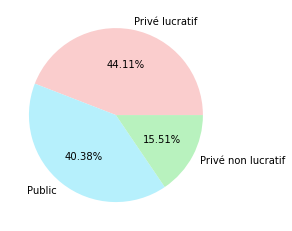

In [151]:
colors = ['#facdcd','#b6f0fc','#b8f2be']
plt.pie(ISA["stjr"].value_counts(), labels = labels_names,
           colors = colors,
           autopct = lambda x: str(round(x, 2)) + '%')

In [152]:
ISA

,Numero_finess,Points_ISA,stjr
0,010008407,165054.798333,1
1,010009132,5715.170000,1
2,010780054,791902.263333,1
3,010780062,188558.060000,1
4,010780096,90756.543333,1
...,...,...,...
482,970462024,20018.590000,2
483,970462073,81023.520000,2
484,970462081,92970.425000,2
485,970462107,306523.591667,2


In [153]:
ISA.describe()

,Points_ISA,stjr
count,1.206000e+03,1206.000000
mean,2.908615e+05,1.713930
std,6.239795e+05,0.717479
min,1.347900e+02,1.000000
25%,2.653193e+04,1.000000
50%,9.898670e+04,2.000000
75%,2.925324e+05,2.000000
max,9.122585e+06,3.000000


In [154]:
ISA[ISA['stjr']==3].describe()

,Points_ISA,stjr
count,1.870000e+02,187.0
mean,1.841910e+05,3.0
std,2.667800e+05,0.0
min,3.831100e+02,3.0
25%,8.885062e+03,3.0
50%,8.223086e+04,3.0
75%,2.483794e+05,3.0
max,1.619194e+06,3.0


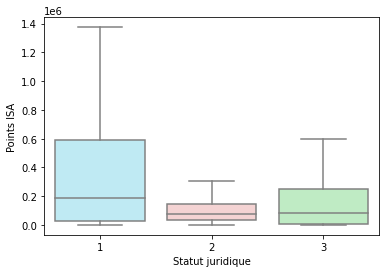

In [155]:
ax =sns.boxplot(x="stjr", y='Points_ISA', data=ISA,showfliers=False, palette=['#b6f0fc','#facdcd','#b8f2be']).set(
    xlabel='Statut juridique', 
    ylabel='Points ISA')

Etude limitée puisque l'on ne connait pas la taille des établissements. 